# MeTRAbsによる動画解析

## ライブラリのインストール

In [1]:
#TensorFlow
import tensorflow as tf

In [2]:
#OpenCV
import cv2

In [3]:
#Matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation#アニメーション用

In [4]:
#データ処理用
import pickle
import numpy as np
import os

# モデルファイルのダウンロード（以下の2つのうちどちらかを実行）

google colab.の場合

In [18]:
def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model

Anacondaの場合

https://github.com/isarandi/metrabs/blob/master/docs/MODELS.md
から対象のファイル（metrabs_mob3l_y4t）をダウンロードして展開したフォルダをmetrabs_movie.ipynbと同じフォルダに置く




In [10]:
model_path = os.path.join(os.path.dirname('./'), 'metrabs_mob3l_y4t')
model = tf.saved_model.load(model_path) # or metrabs_eff2l_y4 for the big model

## 可視化用

In [11]:
skt = []

def visualize_movie(im, detections, poses3d, poses2d, edges):
    global skt
    while len(skt)>0:
        skt.pop(0).remove()
    s = image_ax.imshow(im)
    skt.append(s)
    for x, y, w, h in detections[:, :4]:
        s = image_ax.add_patch(Rectangle((x, y), w, h, fill=False))
        skt.append(s)

    # Matplotlibではz軸が上方向ですが、MeTRabsではy方向が上方向です。そこで、x軸周りに90度回転させています。
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        for i_start, i_end in edges:
            s = image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            skt.append(s[0])
            s = pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
            skt.append(s[0])


# 動画書き出し用

In [12]:
def init():
  pass

def update(n):
    ret, frame = cap.read()

    visualize_movie(
        cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), #画像
        loadpose[n][0], #囲み線
        loadpose[n][1], #3次元位置
        loadpose[n][2], #2次元位置
        model.per_skeleton_joint_edges['smpl_24'].numpy())    
    print(str(n+1)+' / '+str(vf),end='\r')

## 読み込むファイル名の設定

In [13]:
InputName ='d_dance_movie'#'pfm_dance_movie'#

## 3次元解析とデータの保存

In [14]:
cap = cv2.VideoCapture(InputName+'.mp4')

savepose = []

vf = 0
max_vf = 100
while True:
  ret, frame = cap.read()
  if ret:
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    vf = vf+1
    pred = model.detect_poses(image, skeleton='smpl_24')
    savepose.append([pred['boxes'].numpy(),pred['poses3d'].numpy(),pred['poses2d'].numpy()])

  else:
    break
  if vf==max_vf:
    break
print(vf)

with open(InputName+'.pickle', mode='wb') as f:
    pickle.dump(savepose, f)

100


## データの読み込みと動画の書き出し

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

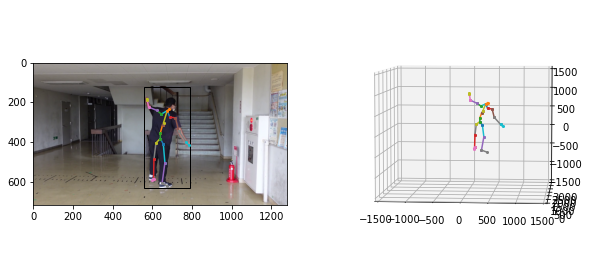

In [15]:
fig = plt.figure(figsize=(10, 5.2))
image_ax = fig.add_subplot(1, 2, 1)
pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
pose_ax.view_init(5, -85)
pose_ax.set_xlim3d(-1500, 1500)
pose_ax.set_zlim3d(-1500, 1500)
pose_ax.set_ylim3d(0, 3000)

cap = cv2.VideoCapture(InputName+'.mp4')

loadpose = []
with open(InputName+'.pickle', mode='rb') as f:
    loadpose = pickle.load(f)

ani = animation.FuncAnimation(fig, update, init_func=init, interval = 1000, frames = vf, repeat=False)

#Google Colab.の場合（Anacondaでもffmpegをインストールすればできる）
ani.save(InputName+'_3d.mp4', writer='ffmpeg')
#Anacondaの場合
#ani.save(InputName+'_3d.gif')


In [16]:
ani.save(InputName+'_3d.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# (参考) YouTubeのダウンロードと変換

## ライブラリのインストール

In [ ]:
!pip install youtube-dl

## 動画のダウンロード

In [ ]:
!youtube-dl 「ここにyoutubeのアドレスを書きます」 -f 22 -o yotubemovie.mp4

## 6秒間の書き出し

In [ ]:
!ffmpeg -i yotubemovie.mp4 -ss 00:00:10 -t 00:00:06 -c:v copy yotubemovie_short.mp4